<a href="https://colab.research.google.com/github/lmencisoe/seguros/blob/main/Modelo_seguros_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install --upgrade pandas-profiling
!pip install nbconvert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import joblib
from xgboost import plot_importance
from google.colab import drive
drive.mount('/content/drive')
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Lectura de datos**

In [9]:
df=pd.read_csv("https://raw.githubusercontent.com/lmencisoe/seguros/main/seguros_database.csv",sep=";")

In [10]:
df2 = df.copy()
#df2 = df2.drop(columns=['ACTECON'])
df2 = df2.drop_duplicates()
df2

,ACTECON,GRUANALI,antigüedad,TAMAEMP,nrotrab,riesgo,categoria,target,modular,prom_antes,cant_antes
0,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__1,0.000000,0
1,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,1457.843500,1
2,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,0.000000,0
3,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,2892.159467,2
5,ACT_ECON_24,GRU_AN_4,10,TAMA__2,37,RIESGO__2,CATEGORIA__4,1,MODULAR__2,472.293400,7
...,...,...,...,...,...,...,...,...,...,...,...
13958,ACT_ECON_5,GRU_AN_13,10,TAMA__2,91,RIESGO__3,CATEGORIA__0,3,MODULAR__0,29127.806530,2
13963,ACT_ECON_5,GRU_AN_13,10,TAMA__2,91,RIESGO__3,CATEGORIA__0,3,MODULAR__0,6807.300000,1
13964,ACT_ECON_33,GRU_AN_9,7,TAMA__2,440,RIESGO__2,CATEGORIA__6,1,MODULAR__0,191.473800,1
13965,ACT_ECON_12,GRU_AN_4,15,TAMA__2,37,RIESGO__3,CATEGORIA__4,2,MODULAR__0,302.441133,2


In [11]:
df2.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# **Definición de X y Y**

In [ ]:
X_total = df2.drop(['target'], axis=1)
Y_total = df2['target'].astype(float) - 1

# **Split de train y test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.2, random_state=2022)

# **Matriz de correlaciones**

<Axes: >

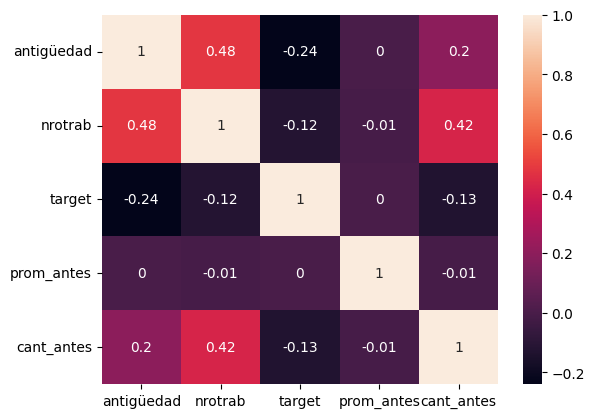

In [ ]:
matriz_correlacion = df2.corr().round(2)
sns.heatmap(data=matriz_correlacion, annot=True)


# **Pipeline de transformmación numérica y categórica**

In [ ]:
cat_features = X_total.select_dtypes(exclude=["float64", "int64"]).columns.to_list()
numeric_features = X_total.select_dtypes(["float64", "int64"]).columns.to_list()

categorical_transformer = Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('encoder', OneHotEncoder())
            ]
        )    

numeric_transformer = Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('scaler', StandardScaler())
            ]
        )

preprocessor = ColumnTransformer(
            transformers=[
                ('numerical', numeric_transformer, numeric_features),
                ('categorical', categorical_transformer, cat_features),
            ],
    remainder='passthrough'
        )

In [ ]:
xgb_pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "classifier", XGBClassifier(),
                ),
            ]
        )

**Balanceo de datos**

In [ ]:
kwargs = {xgb_pipeline.steps[-1][0] + '__sample_weight': sample_weights}   

In [ ]:
sample_weights = compute_sample_weight(
class_weight='balanced',
y=y_train #provide your own target name
)

***Pipeline de XGBoost***


In [ ]:
xgb_param_grid = {
    'classifier__learning_rate': np.arange(0.05, 0.5, 0.05), #tasa de aprendizaje
    'classifier__max_depth': np.arange(10, 40, 1), #profundidad del arbol
    'classifier__n_estimators': np.arange(10, 40, 1), #cantidad de árboles
    'classifier__subsample': np.arange(0.05, 0.5, 0.05), #% de filas
    'classifier__colsample_bytree': np.arange(0.05, 0.5, 0.05) #%de columnas
}

randomized_xgb = RandomizedSearchCV(estimator=xgb_pipeline, 
                                            param_distributions=xgb_param_grid,
                                            n_iter=200,
                                            #scoring='roc_auc',
                                            cv=5, 
                                            verbose=1)

with tf.device('/device:GPU:0'): 
  randomized_xgb.fit(X_train, y_train, **kwargs)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


In [ ]:
print(randomized_xgb.best_params_)

{'classifier__subsample': 0.2, 'classifier__n_estimators': 37, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.25, 'classifier__colsample_bytree': 0.15000000000000002}


*Classification report de train*

In [ ]:
y_pred_train = randomized_xgb.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.62      0.92      0.74       817
         1.0       0.62      0.88      0.73       199
         2.0       0.99      0.95      0.97      7032
         3.0       0.95      0.89      0.92      2484

    accuracy                           0.93     10532
   macro avg       0.80      0.91      0.84     10532
weighted avg       0.95      0.93      0.94     10532



*Classification report de test*

In [ ]:
y_pred_test = randomized_xgb.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.57      0.86      0.68       231
         1.0       0.52      0.70      0.60        50
         2.0       0.99      0.94      0.96      1748
         3.0       0.93      0.84      0.88       605

    accuracy                           0.91      2634
   macro avg       0.75      0.84      0.78      2634
weighted avg       0.93      0.91      0.91      2634



***Pipeline de Decision Tree***


In [ ]:
dt_pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "classifier", DecisionTreeClassifier(),
                ),
            ]
        )

In [ ]:
dt_param_grid = {
    'classifier__max_depth': np.arange(3, 10, 1),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_samples_split': np.arange(5, 50, 5)
}

# Perform RandomizedSearchCV
randomized_roc_auc_dt = RandomizedSearchCV(estimator= dt_pipeline, 
                                            param_distributions=dt_param_grid,
                                            n_iter=100,
                                            #scoring='roc_auc',
                                            cv=5, 
                                            verbose=1)

# Fit the estimator
with tf.device('/device:GPU:0'): 
  randomized_roc_auc_dt.fit(X_train, y_train, **kwargs)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


*Classification report de train*

In [ ]:
y_pred_train = randomized_roc_auc_dt.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.33      0.81      0.47       817
         1.0       0.27      0.40      0.32       199
         2.0       0.97      0.88      0.92      7032
         3.0       0.99      0.73      0.84      2484

    accuracy                           0.83     10532
   macro avg       0.64      0.70      0.64     10532
weighted avg       0.91      0.83      0.86     10532



*Classification report de test*

In [ ]:
y_pred_test = randomized_roc_auc_dt.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.33      0.77      0.47       231
         1.0       0.21      0.34      0.26        50
         2.0       0.97      0.87      0.92      1748
         3.0       0.99      0.73      0.84       605

    accuracy                           0.82      2634
   macro avg       0.63      0.68      0.62      2634
weighted avg       0.90      0.82      0.85      2634



**Pipeline de Random Forest**

In [ ]:
rf_pipeline = Pipeline(
            [
                ("preprocessor", preprocessor),
                (
                    "classifier", RandomForestClassifier(),
                ),
            ]
        )

In [ ]:
rf_param_grid = {
    'classifier__n_estimators': np.arange(3, 100, 1),
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': np.arange(5, 20, 1),
    'classifier__min_samples_split': np.arange(5, 50, 5),
    'classifier__max_features': ['sqrt', 'log2']
}

# Perform RandomizedSearchCV
randomized_rf = RandomizedSearchCV(estimator= rf_pipeline, 
                                            param_distributions=rf_param_grid,
                                            n_iter=100,
                                            #scoring='roc_auc',
                                            cv=5, 
                                            verbose=1)

# Fit the estimator
with tf.device('/device:GPU:0'): 
  randomized_rf.fit(X_train, y_train, **kwargs)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
y_pred_train = randomized_rf.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.45      0.93      0.61       817
         1.0       0.46      0.82      0.59       199
         2.0       0.99      0.93      0.96      7032
         3.0       1.00      0.77      0.87      2484

    accuracy                           0.89     10532
   macro avg       0.73      0.86      0.76     10532
weighted avg       0.94      0.89      0.90     10532



In [ ]:
y_pred_test = randomized_rf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.46      0.87      0.60       231
         1.0       0.33      0.62      0.43        50
         2.0       0.98      0.92      0.95      1748
         3.0       0.99      0.76      0.86       605

    accuracy                           0.87      2634
   macro avg       0.69      0.79      0.71      2634
weighted avg       0.93      0.87      0.89      2634



# **Ajuste de modelo seleccionado**

In [ ]:
X_total[['antigüedad', 'nrotrab', 'prom_antes', 'cant_antes']] = StandardScaler().fit_transform(X_total[['antigüedad', 'nrotrab', 'prom_antes', 'cant_antes']])
X_numeric = X_total[['antigüedad', 'nrotrab', 'prom_antes', 'cant_antes']]
X_numeric =  X_numeric.reset_index(drop=True)

In [ ]:
ACTECON_dummies = pd.get_dummies(X_total['ACTECON'], prefix='').reset_index(drop=True)
GRUANALI_dummies = pd.get_dummies(X_total['GRUANALI'], prefix='').reset_index(drop=True)
TAMAEMP_dummies = pd.get_dummies(X_total['TAMAEMP'], prefix='').reset_index(drop=True)
riesgo_dummies = pd.get_dummies(X_total['riesgo'], prefix='').reset_index(drop=True)
categoria_dummies = pd.get_dummies(X_total['categoria'], prefix='').reset_index(drop=True)
modular_dummies = pd.get_dummies(X_total['modular'], prefix='').reset_index(drop=True)
X_base = X_total[['ACTECON']]

In [ ]:
X_base = pd.concat([X_base.reset_index(drop=True), ACTECON_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), GRUANALI_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), TAMAEMP_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), riesgo_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), categoria_dummies], axis=1)
X_base = pd.concat([X_base.reset_index(drop=True), modular_dummies], axis=1)
X_base = pd.DataFrame(X_base)
X_base = X_base.drop(['ACTECON'], axis=1)
X_base

,_ACT_ECON_1,_ACT_ECON_10,_ACT_ECON_11,_ACT_ECON_12,_ACT_ECON_13,_ACT_ECON_14,_ACT_ECON_15,_ACT_ECON_16,_ACT_ECON_17,_ACT_ECON_18,...,_CATEGORIA__1,_CATEGORIA__2,_CATEGORIA__3,_CATEGORIA__4,_CATEGORIA__5,_CATEGORIA__6,_CATEGORIA__7,_MODULAR__0,_MODULAR__1,_MODULAR__2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
13164,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
X_model = pd.concat([X_base.reset_index(drop=True), X_numeric], axis=1)
X_model = pd.DataFrame(X_model)
X_model

,_ACT_ECON_1,_ACT_ECON_10,_ACT_ECON_11,_ACT_ECON_12,_ACT_ECON_13,_ACT_ECON_14,_ACT_ECON_15,_ACT_ECON_16,_ACT_ECON_17,_ACT_ECON_18,...,_CATEGORIA__5,_CATEGORIA__6,_CATEGORIA__7,_MODULAR__0,_MODULAR__1,_MODULAR__2,antigüedad,nrotrab,prom_antes,cant_antes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.681729,-0.781544,-0.020294,-0.836513
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.010954,-0.835724
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.020294,-0.836513
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.001765,-0.834934
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.681729,-0.781544,-0.017268,-0.830985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.681729,-0.757704,0.166318,-0.834934
13162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.681729,-0.757704,0.023318,-0.835724
13163,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,-0.849109,-0.603628,-0.019067,-0.835724
13164,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.402762,-0.781544,-0.018356,-0.834934


In [ ]:
#X_model.profile_report()

<Axes: >

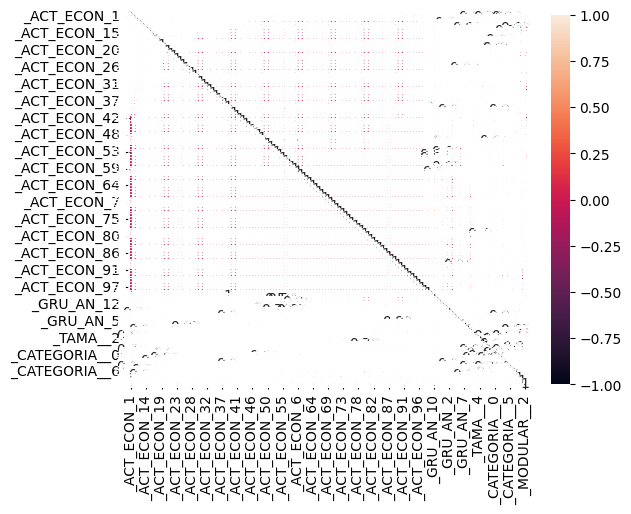

In [ ]:
matriz_correlacion = X_base.corr().round(2)
sns.heatmap(data=matriz_correlacion, annot=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_model, Y_total, test_size=0.2, random_state=2022)

In [ ]:
sample_weights = compute_sample_weight(
class_weight='balanced',
y=y_train #provide your own target name
)

In [ ]:
print(randomized_xgb.best_params_)

{'classifier__subsample': 0.2, 'classifier__n_estimators': 37, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.25, 'classifier__colsample_bytree': 0.15000000000000002}


In [ ]:
xgb_selecc = xgb.XGBClassifier(nthread=3, #when use hyperthread, xgboost may become slower
         objective='multi:softprob',
         learning_rate= 0.15, #so called `eta` value
         max_depth= 20,
         n_estimators = 37,
         subsample= 0.2,
         colsample_bytree = 0.15,
         seed = 2022)


In [ ]:
xgb_selecc.fit(X_train,
         y_train,  
         eval_metric="mlogloss",
         sample_weight = sample_weights,
         early_stopping_rounds=100,
         eval_set = [(X_train, y_train),(X_test, y_test)])

[0]	validation_0-mlogloss:1.16871	validation_1-mlogloss:1.17671
[1]	validation_0-mlogloss:0.95928	validation_1-mlogloss:0.97304
[2]	validation_0-mlogloss:0.85260	validation_1-mlogloss:0.86976
[3]	validation_0-mlogloss:0.75258	validation_1-mlogloss:0.77185
[4]	validation_0-mlogloss:0.66832	validation_1-mlogloss:0.69236
[5]	validation_0-mlogloss:0.59746	validation_1-mlogloss:0.62257
[6]	validation_0-mlogloss:0.57097	validation_1-mlogloss:0.60106
[7]	validation_0-mlogloss:0.54357	validation_1-mlogloss:0.57871
[8]	validation_0-mlogloss:0.51379	validation_1-mlogloss:0.55074
[9]	validation_0-mlogloss:0.46257	validation_1-mlogloss:0.50150
[10]	validation_0-mlogloss:0.44410	validation_1-mlogloss:0.48392
[11]	validation_0-mlogloss:0.41857	validation_1-mlogloss:0.46055
[12]	validation_0-mlogloss:0.38710	validation_1-mlogloss:0.43081
[13]	validation_0-mlogloss:0.37798	validation_1-mlogloss:0.42479
[14]	validation_0-mlogloss:0.36308	validation_1-mlogloss:0.41197
[15]	validation_0-mlogloss:0.35911	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.15, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=37, n_jobs=None, nthread=3, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [ ]:
y_pred_train = xgb_selecc.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.64      0.92      0.75       817
         1.0       0.57      0.88      0.69       199
         2.0       0.99      0.95      0.97      7032
         3.0       0.95      0.88      0.92      2484

    accuracy                           0.93     10532
   macro avg       0.79      0.91      0.83     10532
weighted avg       0.95      0.93      0.93     10532



In [ ]:
y_pred_test = xgb_selecc.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.56      0.82      0.67       231
         1.0       0.44      0.68      0.54        50
         2.0       0.98      0.94      0.96      1748
         3.0       0.93      0.85      0.89       605

    accuracy                           0.90      2634
   macro avg       0.73      0.82      0.76      2634
weighted avg       0.93      0.90      0.91      2634



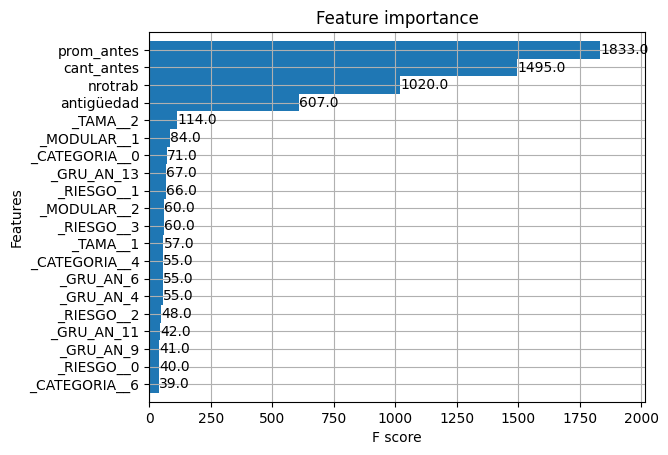

In [ ]:
plot_importance(xgb_selecc, height = 1, max_num_features = 20)
pyplot.show()

In [ ]:
#X_test.to_csv('folder/subfolder/out.csv')  

In [ ]:
xgb_selecc.predict_proba(X_test)

array([[0.01170901, 0.00429687, 0.9790911 , 0.00490305],
       [0.0070407 , 0.0046698 , 0.93906033, 0.04922916],
       [0.00197413, 0.00348761, 0.00348413, 0.9910541 ],
       ...,
       [0.00382636, 0.00422639, 0.9377864 , 0.0541609 ],
       [0.00272032, 0.00309998, 0.9929893 , 0.00119036],
       [0.01424372, 0.01496139, 0.9574005 , 0.01339437]], dtype=float32)

In [ ]:
x_prueba = pd.DataFrame(X_test.iloc[[100]])
x_prueba

,_ACT_ECON_1,_ACT_ECON_10,_ACT_ECON_11,_ACT_ECON_12,_ACT_ECON_13,_ACT_ECON_14,_ACT_ECON_15,_ACT_ECON_16,_ACT_ECON_17,_ACT_ECON_18,...,_CATEGORIA__5,_CATEGORIA__6,_CATEGORIA__7,_MODULAR__0,_MODULAR__1,_MODULAR__2,antigüedad,nrotrab,prom_antes,cant_antes
5491,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.960695,-0.786842,0.033648,-0.828615


In [ ]:
xgb_selecc.predict_proba(x_prueba)

array([[0.00380853, 0.00682524, 0.9372413 , 0.05212493]], dtype=float32)